# Language

[TODO]

In [2]:
import os
from dotenv import load_dotenv

load_dotenv();

In [17]:
from pathlib import Path
import json
import pickle
from collections import Counter
import warnings

import tqdm 
import torch
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
from mpl_toolkits.mplot3d import Axes3D

from icl.constants import DEVICE, DATA, ANALYSIS
from icl.language.model import get_model
from icl.language.utils import translate_int_to_str
from icl.figures.colors import plot_transitions, gen_transition_colors, get_transition_type, PRIMARY, SECONDARY, TERTIARY, BRED, BBLUE, BRED, BGREEN
from icl.figures.plotting import WIDTH, HEIGHT, FULL_WIDTH, FULL_HEIGHT

warnings.filterwarnings('ignore')

model = get_model()
AWS_BUCKET_NAME = os.getenv("AWS_BUCKET_NAME")

plt.rcParams['figure.dpi'] = 300


Using pad_token, but it is not set yet.


# Figure 1

In [4]:
llc2_mean_df = pd.read_csv(ANALYSIS / 'language/L2W256-llc_1.csv')
llc2_std_df = pd.read_csv(ANALYSIS / 'language/L2W256-llc-std_1.csv')

llc2_mean_df = llc2_mean_df[['Step', 'L2W256-3M-LLC-rr - llc/mean']]
llc2_mean_df = llc2_mean_df.rename(columns={'L2W256-3M-LLC-rr - llc/mean': 'llc_mean'})
print(llc2_mean_df.head())

llc2_std_df = llc2_std_df[['Step', 'L2W256-3M-LLC-rr - llc/std']]
llc2_std_df = llc2_std_df.rename(columns={'L2W256-3M-LLC-rr - llc/std': 'llc_std'})
print(llc2_std_df.head())

steps = llc2_mean_df['Step'].values
losses = np.loadtxt(ANALYSIS / 'language/L2W256-losses.txt')
losses_df = pd.DataFrame({"Step": step, "loss": loss} for step, loss in zip(steps, losses))
print(losses_df.head())

   Step    llc_mean
0     0  123.559990
1   100  137.331192
2   200  143.640503
3   300  146.997894
4   400  148.288742
   Step    llc_std
0     0  50.648117
1   100  32.966717
2   200  30.679647
3   300  29.764782
4   400  29.250549
   Step      loss
0     0  8.966071
1   100  7.945969
2   200  7.749671
3   300  7.391308
4   400  7.253851


In [5]:
import numpy as np
from sklearn.decomposition import PCA
import pickle

with open(ANALYSIS / 'language/L2W256-per-token-logits.pkl', 'rb') as f:
    per_token_loss = pickle.load(f)

per_token_loss = np.array(per_token_loss)
print(per_token_loss.shape)

pca = PCA(n_components=3)
pca.fit(per_token_loss)
projections = pca.transform(per_token_loss)
pca.fit(per_token_loss)
projections = pca.transform(per_token_loss)
pca.explained_variance_ratio_

(501, 10000)


array([0.64620149, 0.08539305, 0.04737232])

In [6]:
from icl.analysis.smoothing import gaussian_filter1d_variable_sigma

sigmas = np.linspace(1, 50, len(projections))
smoothed_projections = gaussian_filter1d_variable_sigma(projections, sigmas, axis=0)

In [7]:
from icl.figures.colors import gen_transition_colors

TRANSITIONS = [
    (0, 900, "LM1"),
    (900, 6500, "LM2"),
    (6500, 8500, "LM3"),
    (8500, 17_500, "LM4"),
    (17_500, 49_900, "LM5")
]

colors = gen_transition_colors(['A', 'A', 'A', 'B', 'A', 'Other']) # sns.color_palette("coolwarm_r", n_colors=len(TRANSITIONS))
colors = colors[1:]

In [8]:
with open(ANALYSIS / "language/lm_test_loss.pkl", "rb") as f:
    test_loss = pickle.load(f)

with open(ANALYSIS / 'language/norms.pkl', 'rb') as f:
    norms = pickle.load(f)

MODEL_ID = "LM1"

df = llc2_mean_df.merge(llc2_std_df, on='Step').merge(losses_df, on='Step')
# Rename column Steps to step
df = df.rename(columns={'Step': 'step'})
df['weight/norm'] = norms[:-1]
df['loss'] = test_loss[:-1]

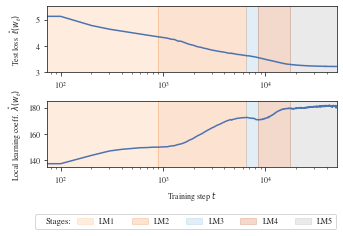

In [13]:
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import matplotlib.lines as mlines
from icl.constants import FIGURES

sns.set_palette('deep')

# Data setup (use your actual data here)
# For demonstration, replace evals_over_time_df with your DataFrame
# evals_over_time_df = ...

# Create figure
fig, axs = plt.subplots(2, 1, figsize=(WIDTH * 1.5, HEIGHT * 1.5))

axs[0].set_ylabel(r'Test loss  $\hat{\ell}(w_t)$' '\n')
axs[1].set_ylabel(r'Local learning coeff.  $\hat\lambda(w_t)$')
# First line plot
sns.lineplot(df, x='step', y='loss', ax=axs[0])
# axs[0].set_title(r'(a) Loss over Time')
axs[0].set_xscale('log')
#axs[0].set_yscale('log')
# axs[0].set_xlim(100, 500_000)

# Second line plot
sns.lineplot(llc2_mean_df, x='Step', y='llc_mean', ax=axs[1])
# axs[1].set_title(r'(c) Local Learning Coefficient over Time')
axs[1].set_xscale('log')
# axs[1].set_xlim(100, 500_000)
 
handles = plot_transitions(axs, TRANSITIONS, xlim=True, colors=colors) 
# Set x-label for both plots
# for ax in axs:
axs[0].set_xlabel('')
axs[1].set_xlabel('Training step $t$')

axs[0].set_ylim(3, 5.5)
axs[1].set_ylim(135, 185)

# fig.legend(handles=handles, loc='upper center', bbox_to_anchor=(0.55, 0.01), ncol=len(TRANSITIONS))
labels = [t[2] for t in TRANSITIONS]
dummy = mlines.Line2D([], [], color='none', label='')
legend = fig.legend(handles=[dummy] + handles, labels=[""] + labels, loc='upper center', bbox_to_anchor=(0.54, 0.01), ncol=len(TRANSITIONS)+1)
fig.text(0.14, -0.058, 'Stages:', horizontalalignment='left', verticalalignment='bottom', zorder=1000, fontsize=9)


# axs[1].legend(handles=handles, loc='upper center', bbox_to_anchor=(0.5, -0.2), ncol=len(TRANSITIONS))
# Layout adjustments
plt.tight_layout()
fig.set_facecolor('white')

fig.savefig(FIGURES / f"language/lm-fig1-top.pdf", bbox_inches='tight')
plt.show()

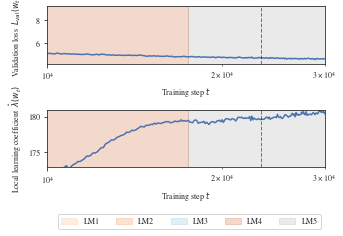

In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

from icl.constants import FIGURES

sns.set_palette('deep')

# Data setup (use your actual data here)
# For demonstration, replace evals_over_time_df with your DataFrame
# evals_over_time_df = ...

# Create figure
fig, axs = plt.subplots(2, 1, figsize=(WIDTH * 1.5, HEIGHT * 1.5))

# First line plot
# axs[0].set_title(r'(a) Loss over Time')
#axs[0].set_yscale('log')
# axs[0].set_xlim(100, 500_000)
axs[0].set_xscale('log')
axs[0].set_ylabel(r'Validation loss  $L_{\mathrm{val}}(w_t)$' '\n')
axs[0].set_xlabel('')
axs[1].set_xlabel('Training step $t$')
axs[1].set_ylim(173, 181)
axs[1].set_xscale('log')
axs[1].set_ylabel(r'Local learning coefficient  $\hat\lambda(w_t)$')


# Second line plot
sns.lineplot(losses_df, x='Step', y='loss', ax=axs[0])
sns.lineplot(llc2_mean_df, x='Step', y='llc_mean', ax=axs[1])
# axs[1].set_title(r'(c) Local Learning Coefficient over Time')
# axs[1].set_xlim(100, 500_000)
 
# Set x-label for both plots
# for ax in axs:

handles = plot_transitions(axs, TRANSITIONS, xlim=(100, 500_000), colors=colors) 

fig.legend(handles=handles, loc='upper center', bbox_to_anchor=(0.55, 0.01), ncol=len(TRANSITIONS))

for ax in axs:
    ax.set_xlim(10_000, 30_000)
    ax.axvline(23_300, color='black', linestyle='--', linewidth=1, alpha=0.5)


# axs[1].legend(handles=handles, loc='upper center', bbox_to_anchor=(0.5, -0.2), ncol=len(TRANSITIONS))
# Layout adjustments
plt.tight_layout()
fig.set_facecolor('white')

fig.savefig(FIGURES / f"language/lm-fig1-top-zoom.pdf", bbox_inches='tight')
plt.show()



\hat\ell(w_t)
LM1 0: Original: 7.943367143026904 Smoothed: -0.5576635786336122 
LM2 900: Original: 4.346282958984375 Smoothed: -0.24235060458275678 
LM3 6500: Original: 3.63262939453125 Smoothed: -0.22510496381501827 
LM4 8500: Original: 3.5568618774414062 Smoothed: -0.3982012791047653 
LM5 17500: Original: 3.2945556640625 Smoothed: -0.2003130232670226 
End 50k: Original:  3.2172393798828125 Smoothed:  -0.017107347468730938

\hat \lambda(w_t)
LM1 0: Original: 123.55998992918687 Smoothed: 6.075979601663331 
LM2 900: Original: 149.95361328125 Smoothed: 0.8313697273890213 
LM3 6500: Original: 172.46533203125 Smoothed: -0.4602358305461883 
LM4 8500: Original: 170.90432739257812 Smoothed: -2.4815582559506018 
LM5 17500: Original: 179.281005859375 Smoothed: 0.10700044229007608 
End 50k: Original:  180.38671875 Smoothed:  -41.464075425950966
Indices where |derivy| < .25:  [16700 17200 17500 17600 17700 18000 18400 31400 33000 33300 39400 43100
 44400 45300 45700 45900 47600]

|w_t|
LM1 0: Or

╭─────────────────────────────── Traceback (most recent call last) ────────────────────────────────╮
│ in <module>:128                                                                                  │
╰──────────────────────────────────────────────────────────────────────────────────────────────────╯
NameError: name 'FIGURES' is not defined

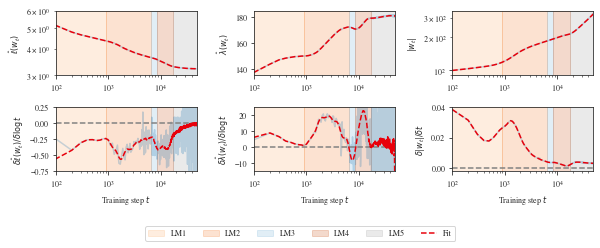

In [9]:
from matplotlib import lines as mlines
from sklearn.gaussian_process import GaussianProcessRegressor
from sklearn.gaussian_process.kernels import RBF, ConstantKernel as C
from icl.figures.derivatives import d_dt

from icl.figures.notation import str_d_dlogt, str_d_dt, str_dlog_dlogt
from icl.figures.colors import plot_transitions, gen_transition_colors, get_transition_type, PRIMARY, SECONDARY, TERTIARY, BRED, BBLUE, BRED, BGREEN

plt.rcParams['figure.dpi'] = 300

metrics_to_plot = [
    (r"\hat\ell(w_t)", "loss", {"logy": True, "derivative": "d_dlogt", "spline": True, "s": 0.1}, ),
    # (r"L_\mathcal{G}(t)", df["true/mse"], {"logy": False}),
    (r"\hat \lambda(w_t)", 'llc_mean', {"derivative": "d_dlogt", "spline": True}),
    (r"|w_t|", "weight/norm", {"derivative": "d_dt", "logy": True, "spline": True, "s": 0.1}),
] 
fig, axes = plt.subplots(2, len(metrics_to_plot), figsize=(FULL_WIDTH * 1.25, FULL_HEIGHT * 1.5))

# axes = np.array(axes)
axes = axes.reshape(2, len(metrics_to_plot))

def str_dlog_dlogt(s):
    return r"$\delta \log " + s + r"/\delta\log t$"

for i, (metric_name, metric_key, kwargs) in enumerate(metrics_to_plot):
    use_spline = kwargs.get("spline", False)

    sns.lineplot(data=df, x="step", y=df[metric_key], ax=axes[0, i],label=metric_name, alpha=1 - use_spline * 0.75)
    # axes[0, i].plot(df['step'], metric_values, label=metric_name, marker='.')
    axes[0, i].set_title(f"")
    axes[0, i].set_xlabel('')
    axes[0, i].set_ylabel(f"${metric_name}$")

    if kwargs.get("logy", False):
        axes[0, i].set_yscale('log')

    axes[0, i].legend().remove()

    slope_type = kwargs.get("derivative", "d_dlogt")

    if slope_type == "d_dlogt":
        slope_name = str_d_dlogt(metric_name)
        ys = d_dt(np.log(df['step'].values), df[metric_key].values)
    elif slope_type == "d_dt":
        slope_name = str_d_dt(metric_name)
        ys = d_dt(df['step'].values, df[metric_key].values)
    elif slope_type == "dlog_dlogt":
        slope_name = str_dlog_dlogt(metric_name)
        ys = d_dt(np.log(df['step'].values), np.log(df[metric_key].values))
    else:
        raise ValueError(f"Unknown slope type {slope_type}")

    sns.lineplot(data=df, x="step", y=ys, ax=axes[1, i], label=metric_name + " Slope", alpha=1 - use_spline * 0.75)
    axes[1, i].axhline(0, linestyle='--', color='gray')
    axes[1, i].set_title("")
    axes[1, i].set_ylabel(slope_name)
    axes[1, i].legend().remove()
    
    if use_spline:     
        _steps = np.log(np.array(steps) + 1 ).reshape((-1, 1))
        _y = df.groupby('step').mean()[metric_key].values

        kernel = C(1.0, (1e-3, 1e3)) * RBF(3, (5e-1, 1e3))

        # Create a Gaussian Process Regressor
        gp = GaussianProcessRegressor(kernel=kernel, n_restarts_optimizer=10)

        # Fit the Gaussian Process
        gp.fit(_steps, _y)
        _ypred = gp.predict(_steps)

        if slope_type == "d_dlogt":
            _derivy = d_dt(_steps, _ypred)
        elif slope_type == "d_dt":
            _derivy = d_dt(np.exp(_steps), _ypred)
        elif slope_type == "dlog_dlogt":            
            _derivy = d_dt(_steps, np.log(_ypred))
        
        axes[0, i].plot(steps, _ypred, label="Spline", linestyle='--', color=BRED)
        axes[1, i].plot(steps, _derivy, label="Spline", linestyle='--', color=BRED)

        print()
        print(metric_name)
        for t1, t2, label in TRANSITIONS:
            i1, i2 = list(steps).index(t1), list(steps).index(t2)
            print(f"{label} {t1}: Original: {_ypred[i1]} Smoothed: {_derivy[i1]} ")

        print("End 50k: Original: ", _ypred[-1], "Smoothed: ", _derivy[-1])

        # Find indices where |derivy| < 2
        if metric_key == "llc_mean":
            print("Indices where |derivy| < .25: ", steps[np.where(np.abs(_derivy) < .25)[0]])



patch_list = plot_transitions(axes, TRANSITIONS, xlim=True, colors=colors)


for ax in axes[0]:
    ax.set_xlabel('')
    
for ax in axes.flatten():
    ax.set_xscale('log')
    ax.set_xlim(100, 49_000)
    # ax.set_ylabel("")

# axes[1, 1].set_yscale('symlog')
# axes[1, 0].set_yscale('symlog')
# axes[0,0].set_ylim(0, 70)

milestone_labels = [label for _, _, label in TRANSITIONS]
gp_fit_patch = mlines.Line2D([], [], color=BRED, linestyle='--', label="GP Fit")
fig.legend(patch_list + [gp_fit_patch], milestone_labels + ["Fit"], loc='upper center', bbox_to_anchor=(0.5, -0.025), ncol=len(TRANSITIONS) + 1)

fig.set_facecolor("white")
fig.tight_layout()


# axes[0, 1].set_ylim(0, 100)
# axes[1, 0].set_ylim(-2.25, 2.25)
# axes[1, 1].set_ylim(-150, 160)
axes[0, 0].set_ylim(3, 6)
axes[0, 1].set_ylim(135, 185)
axes[1, 0].set_ylim(-.75, .25)
axes[1, 1].set_ylim(-15, 25)
# axes[1, 1].set_ylim(-0.003, .015)

fig.savefig(FIGURES / f"language/{MODEL_ID}-loss-llc-with-slopes.pdf", bbox_inches='tight')

In [ ]:
per_token_loss

[(0, 1), (0, 2), (1, 2)]



100%|██████████| 498/498 [00:00<00:00, 15537.58it/s]

100%|██████████| 498/498 [00:00<00:00, 15410.91it/s]

 90%|████████▉ | 448/500 [03:48<00:26,  1.96it/s]


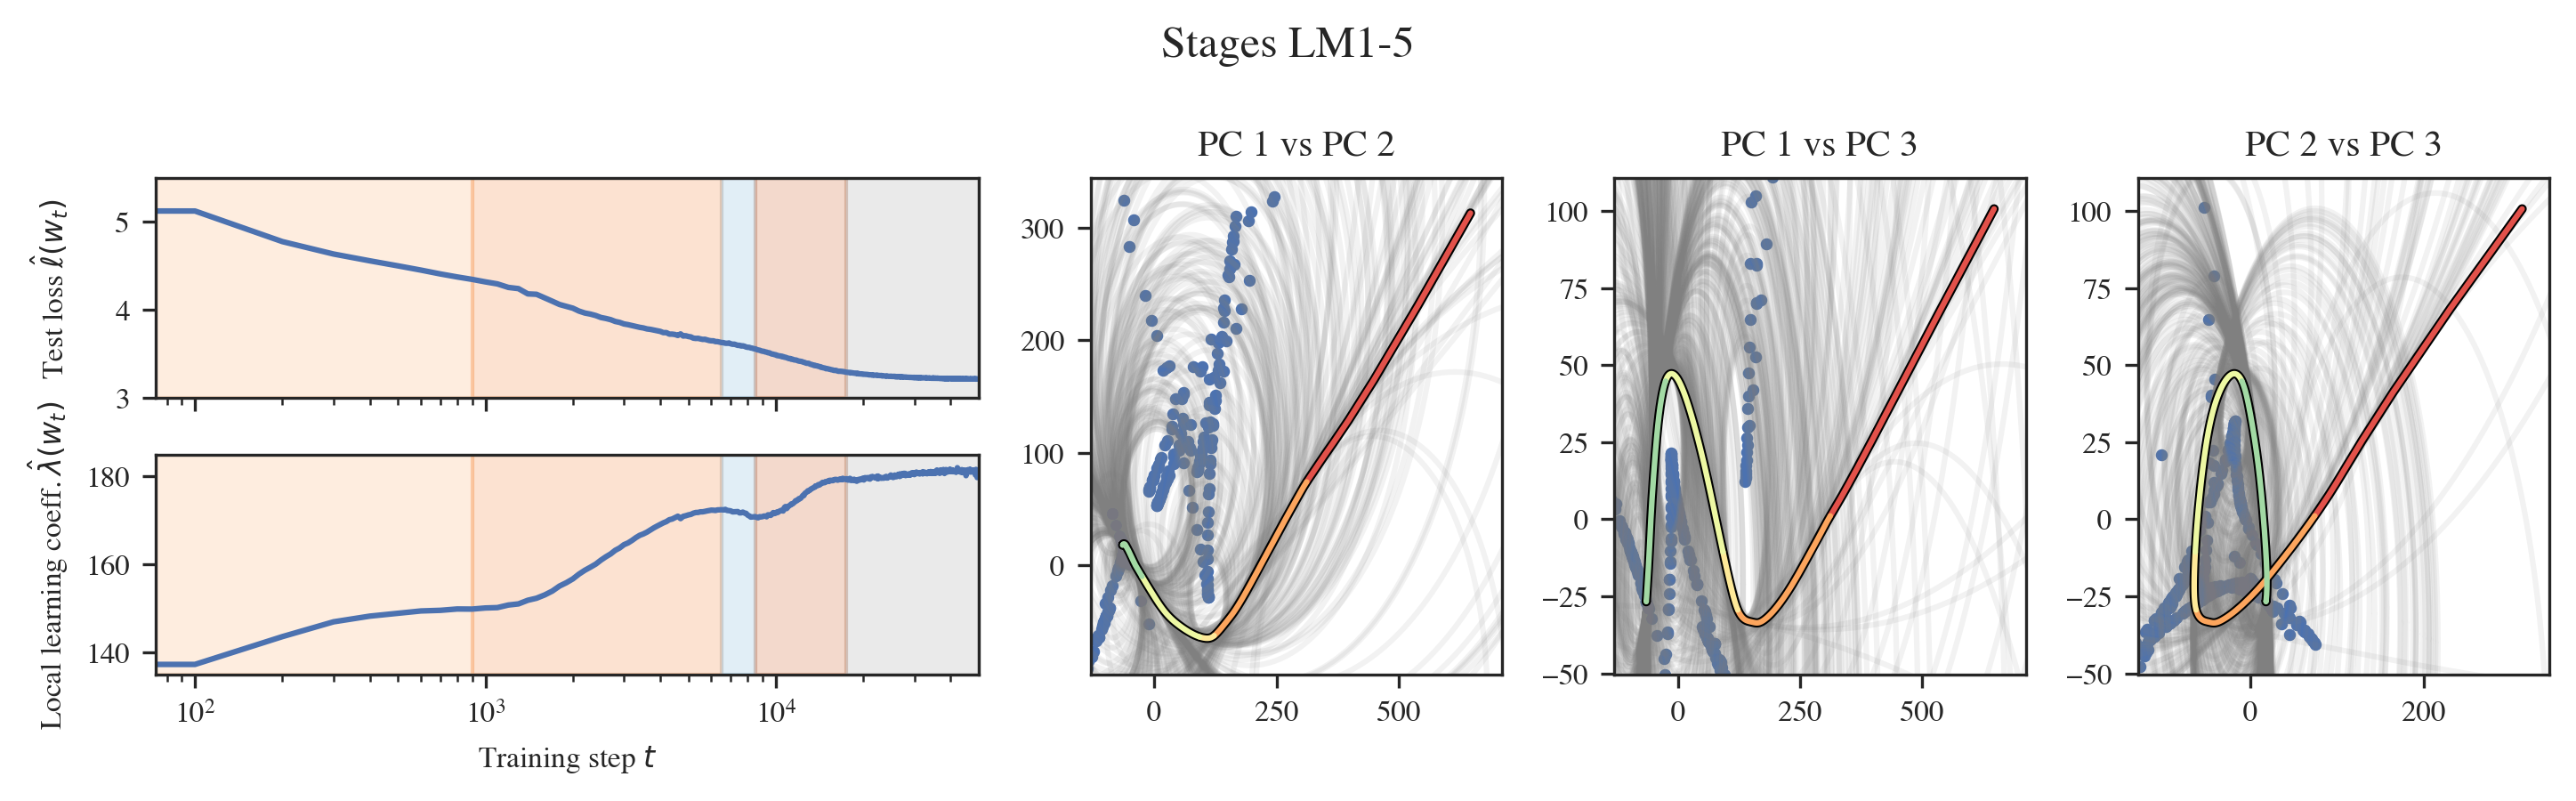

In [18]:
import itertools
from math import isnan
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import matplotlib.lines as mlines
from matplotlib.gridspec import GridSpec
from icl.constants import FIGURES
from devinterp.slt.forms import get_osculating_circle

sns.set_palette('deep')

# Data setup (use your actual data here)
# For demonstration, replace evals_over_time_df with your DataFrame
# evals_over_time_df = ...

# Create figure with GridSpec
fig = plt.figure(figsize=(WIDTH * 3, HEIGHT * 1.5))
gs = GridSpec(2, 4, figure=fig, width_ratios=[2, 1, 1, 1], height_ratios=[1, 1])

LW = 1.5

# First line plot
ax0 = fig.add_subplot(gs[0, 0])
sns.lineplot(df, x='step', y='loss', ax=ax0, lw=LW)
ax0.set_ylabel(r'Test loss $\hat{\ell}(w_t)$' '\n')
ax0.set_xscale('log')
ax0.set_ylim(3, 5.5)

# Second line plot
ax1 = fig.add_subplot(gs[1, 0])
sns.lineplot(llc2_mean_df, x='Step', y='llc_mean', ax=ax1, lw=LW)
ax1.set_ylabel(r'Local learning coeff. $\hat\lambda(w_t)$')
ax1.set_xscale('log')
ax1.set_ylim(135, 185)

# Set x-label for both plots

axes = [ax0, ax1]
handles = plot_transitions(axes, TRANSITIONS, xlim=True, colors=colors)

ax0.set_xlabel('')
ax0.set_xticklabels([])
ax1.set_xlabel('Training step $t$')


traj_colors = sns.palettes.color_palette('Spectral', n_colors=len(TRANSITIONS) + 1)
pc_combos = list(itertools.combinations(list(range(3)), 2))
max_plot = -1 # None # len(steps)
_steps = list(steps)
# Add three new figures on the right-hand side
print(pc_combos)
 

all_centers = []
for (pc1, pc2) in pc_combos:
    centers = []
    for t in tqdm.trange(1, len(_steps)-1):
        center, radius = get_osculating_circle(smoothed_projections[:, [pc1, pc2]], t)
        centers.append((center, radius))

    all_centers.append(centers)

for i, (pc1, pc2) in enumerate(pc_combos):
    ax = fig.add_subplot(gs[:, i+1])
    ax.set_title(f'PC {pc1+1} vs PC {pc2+1}')
    ax.set_xlabel('')
    ax.set_ylabel('')
    
    centers = all_centers[i]

    for (center, radius) in centers:
        if isnan(radius):
            n_thetas = 1000
        else:
            n_thetas = min(int(radius * 100), 1000)

        x=center[0] + radius * np.cos(np.linspace(0, 2 * np.pi, n_thetas))
        y=center[1] + radius * np.sin(np.linspace(0, 2 * np.pi, n_thetas))
        ax.plot(x, y, color='gray', alpha=0.1)    

    ax.scatter([c[0][0] for c in centers], [c[0][1] for c in centers], alpha=1, s=5)
    ax.plot(smoothed_projections[:, pc1], smoothed_projections[:, pc2], color='k', lw=LW+1)
    # ax.scatter(projections[:, pc1], projections[:, pc2], color='r', alpha=.5, s=5)

    for k, (start, end, stage) in enumerate(TRANSITIONS):
        start_idx = _steps.index(start)
        end_idx = _steps.index(end) + 1

        if max_plot > 0:
            if start > max_plot:
                continue

            end_idx = min(end_idx, max_plot)

        # sc = axes[I].scatter(samples[:, i], samples[:, j], c=transition_idxs, cmap=cmap, s=50, alpha=alpha)
        ax.plot(smoothed_projections[start_idx:end_idx, pc1], smoothed_projections[start_idx:end_idx, pc2], color=traj_colors[k], lw=LW)
    
    xmin, xmax = smoothed_projections[:, pc1].min(), smoothed_projections[:, pc1].max()
    ymin, ymax = smoothed_projections[:, pc2].min(), smoothed_projections[:, pc2].max()

    ax.set_xlim(xmin * 2, xmax * 1.1)
    ax.set_ylim(ymin * 1.5, ymax * 1.1)
    
    # Add your plotting code for each new figure here
    # For example:
    # sns.lineplot(data, x='x', y='y', ax=ax)
    # ax.set_title(f'Figure {i}')

# Legend
# labels = [t[2] for t in TRANSITIONS]
# dummy = mlines.Line2D([], [], color='none', label='')
# legend = fig.legend(handles=[dummy] + handles, labels=[""] + labels, loc='upper center', bbox_to_anchor=(0.54, 0.01), ncol=len(TRANSITIONS)+1)
# fig.text(0.14, -0.058, 'Stages:', horizontalalignment='left', verticalalignment='bottom', zorder=1000, fontsize=9)


# Layout adjustments
plt.tight_layout()
plt.suptitle("Stages LM1-5")
fig.set_facecolor('white')
fig.savefig(FIGURES / f"language/lm-fig1-top.pdf", bbox_inches='tight')
plt.show()

In [ ]:
traj_colors

In [ ]:
len(all_centers[0])
























100%|█████████▉| 499/500 [16:51<00:02,  2.03s/it]































































































































































































































































































































































































































































































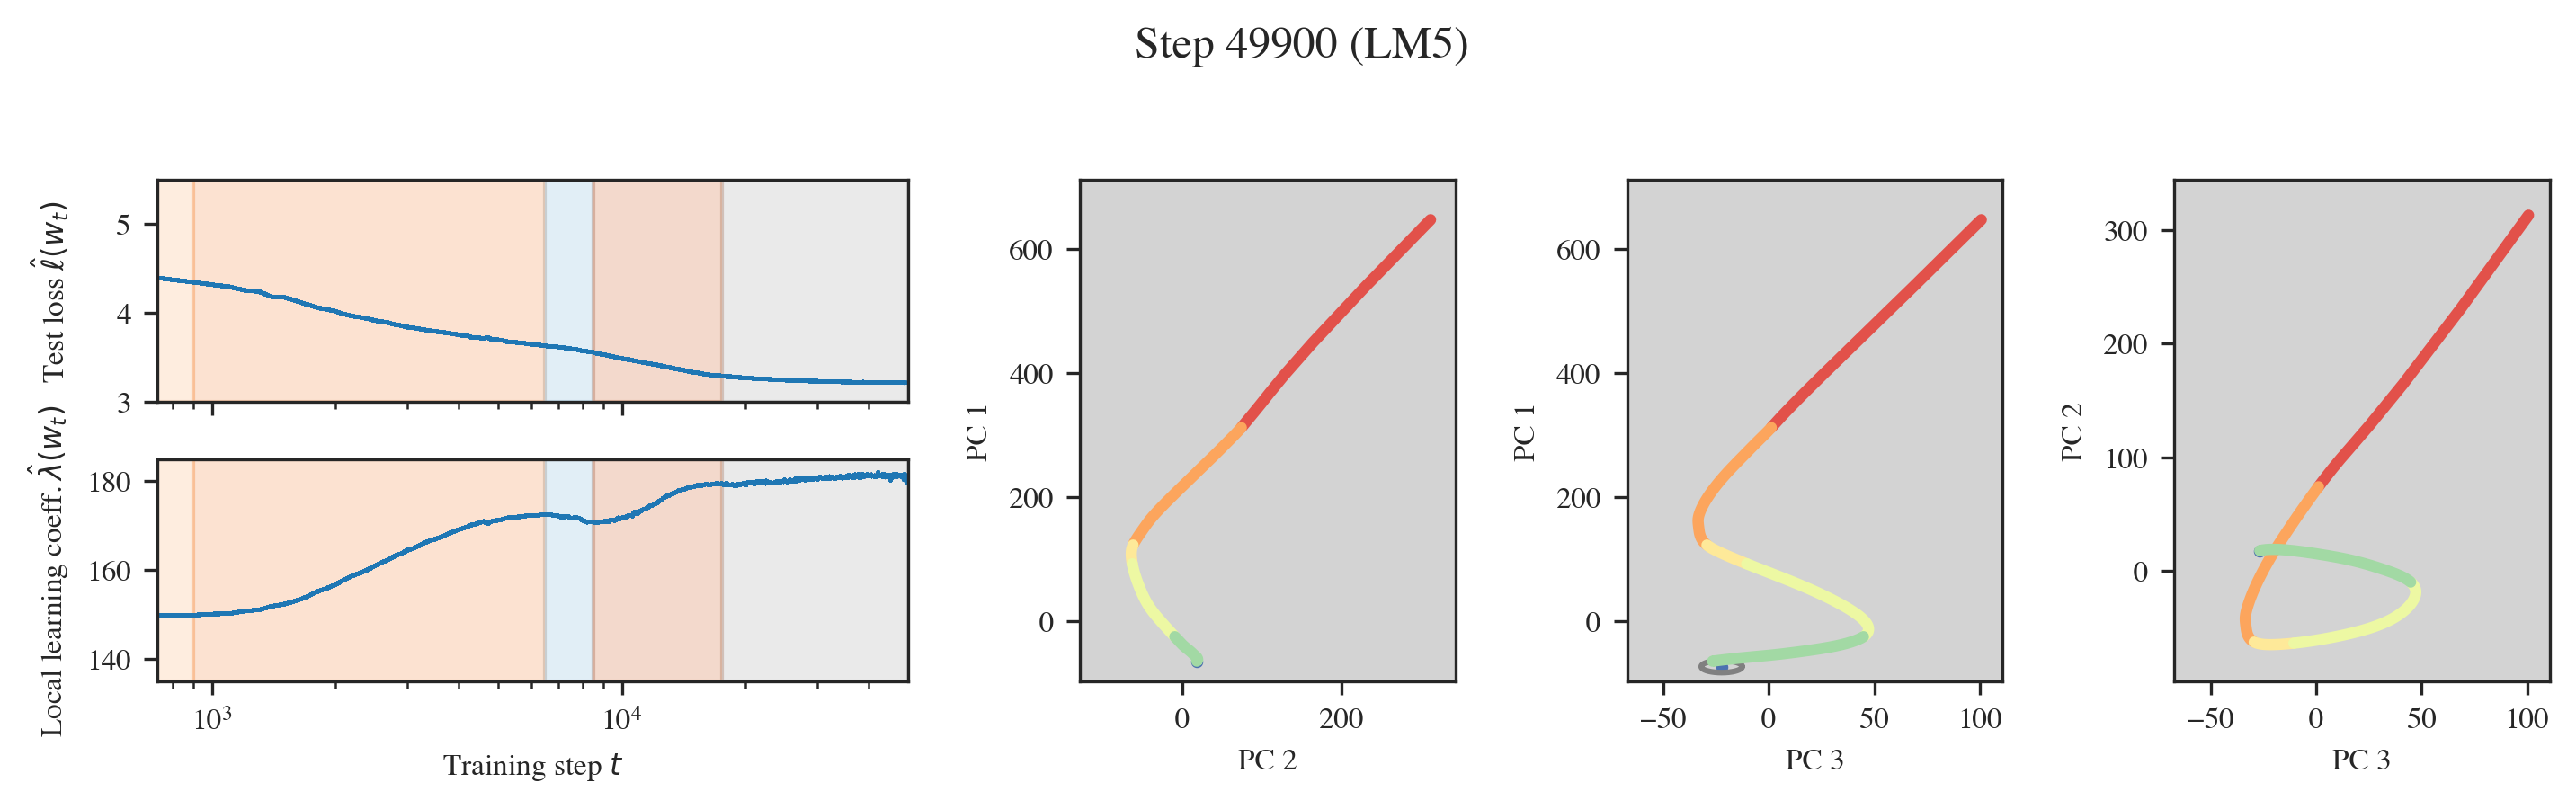

In [22]:
import itertools
from math import isnan
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import matplotlib.lines as mlines
from matplotlib.gridspec import GridSpec
from icl.constants import FIGURES
from devinterp.slt.forms import get_osculating_circle
import matplotlib.animation as animation

sns.set_palette('deep')

# ... (Previous code remains the same) ...
LW = 1.

fig = plt.figure(figsize=(WIDTH * 3, HEIGHT * 1.5))
gs = GridSpec(2, 4, figure=fig, width_ratios=[2, 1, 1, 1], height_ratios=[1, 1])

# First line plot
ax0 = fig.add_subplot(gs[0, 0])
ax0.set_ylim(3, 5.5)

# Second line plot
ax1 = fig.add_subplot(gs[1, 0])
ax1.set_ylim(135, 185)

# Set x-label for both plots
llc_axes = [ax0, ax1]

plot_transitions(llc_axes, TRANSITIONS, xlim=True, colors=colors)
ax0.set_ylabel(r'Test loss $\hat{\ell}(w_t)$' '\n')
ax0.set_xscale('log')
ax1.set_ylabel(r'Local learning coeff. $\hat\lambda(w_t)$')
ax1.set_xscale('log')
ax0.set_xlabel('')
ax0.set_xticklabels([])
ax1.set_xlabel('Training step $t$')

skip = 1

ed_axes = []
lims = []

for i, (pc1, pc2) in enumerate(pc_combos):
    ax = fig.add_subplot(gs[:, i+1])
    ax.set_title(f'PC {pc1+1} vs PC {pc2+1}')
    ax.set_xlabel(f'PC {pc1}')
    ax.set_ylabel(f'PC {pc2}')
        
    ed_axes.append(ax)

    xmin, xmax = smoothed_projections[:, pc1].min(), smoothed_projections[:, pc1].max()
    ymin, ymax = smoothed_projections[:, pc2].min(), smoothed_projections[:, pc2].max()
    lims.append((xmin, xmax, ymin, ymax))

    # bg color
    ax.set_facecolor('lightgray')

# artists = []

plt.tight_layout()

# Looks better after
plt.suptitle("Step 0 (LM1)")

def get_transition(step):
    for start, end, stage in TRANSITIONS:
        if step >= start and step <= end:
            return stage

    raise ValueError(f"Step {step} not in any transition")

def animate(frame):
    max_plot = frame + 1
    max_step = _steps[frame]

    plt.suptitle(f"Step {max_step} ({get_transition(max_step)})")

    for artist in plt.gca().lines:
        artist.remove()

    sns.lineplot(df.loc[df.step <= max_step], x='step', y='loss', ax=ax0, lw=LW, color=PRIMARY)
    sns.lineplot(llc2_mean_df.loc[llc2_mean_df.Step <= max_step], x='Step', y='llc_mean', ax=ax1, lw=LW, color=PRIMARY)
    ax0.set_xlabel('')

    for ax in llc_axes:
        ax.legend().remove()

    for i, (pc2, pc1) in enumerate(pc_combos):
        ax = ed_axes[i]
        ax.clear()
        
        center, radius = all_centers[i][max(0, frame-2)]
        xmin, xmax, ymin, ymax = lims[i]
        
        if isnan(radius):
            n_thetas = 1000
        else:
            n_thetas = min(int(radius * 100), 1000)

        x = center[1] + radius * np.cos(np.linspace(0, 2 * np.pi, n_thetas))
        y = center[0] + radius * np.sin(np.linspace(0, 2 * np.pi, n_thetas))
        ax.plot(x, y, color='gray', alpha=1)

        # ax.scatter([c[0][0] for c in centers], [c[0][1] for c in centers], alpha=1, s=5)
        ax.scatter([center[1]], [center[0]], alpha=1, s=5)
        # ax.plot(smoothed_projections[:max_plot:skip, pc1], smoothed_projections[:max_plot:skip, pc2], color='k', lw=LW+1)
        
        for k, (start, end, stage) in enumerate(TRANSITIONS):
            start_idx = _steps.index(start)
            end_idx = _steps.index(end) + 1
            # print(stage, start_idx, end_idx, max_plot)
            
            if start_idx > max_plot:
                continue
            
            end_idx = min(end_idx, max_plot)
            ax.plot(smoothed_projections[start_idx:end_idx, pc1], smoothed_projections[start_idx:end_idx, pc2], color=traj_colors[k], lw=LW*3)
     
        ax.set_xlabel(f'PC {pc1+1}')
        ax.set_ylabel(f'PC {pc2+1}')

        ax.set_xlim(ymin * 2, ymax * 1.1)
        ax.set_ylim(xmin * 1.5, xmax * 1.1)

# Create the animation
ani = animation.FuncAnimation(fig, animate, frames=tqdm.trange(len(_steps)), interval=10, repeat_delay=2000)

plt.tight_layout()
fig.set_facecolor('white')
ani.save(FIGURES / f"language/lm-fig1-top.gif", writer='pillow')
plt.show()

In [75]:
import csv


with open(ANALYSIS / "language/L2-bigram-score.pkl", "rb") as f:
    bigram_score = pickle.load(f)

with open(ANALYSIS / "language/bigram_entropy.pkl", "rb") as f:
    bigram_entropy = pickle.load(f)

with open(ANALYSIS / "language/L2-n-grams.pkl", "rb") as f:
    ngrams = pickle.load(f)

# L2-icl-score, L2-prefix-scores, L2-prev-scores
with open(ANALYSIS / "language/L2-icl-score.csv", "r") as f:
    icl_score_df = pd.read_csv(f)
    print(icl_score_df.head())
    icl_score = icl_score_df['L2W256-3m-rr-ICL - icl-loss'].values

with open(ANALYSIS / "language/L2-prefix-scores.pkl", "rb") as f:
    prefix_scores = np.array(pickle.load(f))

with open(ANALYSIS / "language/L2-prev-scores.pkl", "rb") as f:
    prev_scores = np.array(pickle.load(f))

# Put this all together in a matrix together with loss & LLC scores from above

steps = list(range(0, 50_001, 100))
llcs = llc2_mean_df['llc_mean'].values
loss = df['loss'].values

print(len(list(range(0, 50_001, 100))))
print(len(list(loss) + [loss[-1]]))
print(len(list(llcs) + [llcs[-1]]))
print(bigram_score)
print(bigram_entropy)
print(ngrams.keys())
print(prefix_scores.shape)
print(prev_scores.shape)
print(icl_score.shape)

df = pd.DataFrame({
    "step": steps,
    "loss": list(loss),
    "llc": list(llcs) + [llcs[-1]],
    "bigram_score": bigram_score,
    "icl_score": icl_score,
})

   Step  L2W256-3m-rr-ICL - icl-loss  L2W256-3m-rr-ICL - icl-loss__MIN  \
0     0                    -0.122264                         -0.122264   
1   100                    -0.067171                         -0.067171   
2   200                    -0.079183                         -0.079183   
3   300                    -0.077179                         -0.077179   
4   400                    -0.069354                         -0.069354   

   L2W256-3m-rr-ICL - icl-loss__MAX  
0                         -0.122264  
1                         -0.067171  
2                         -0.079183  
3                         -0.077179  
4                         -0.069354  
501
502
501
[7.947368653726578, 5.105565355086327, 4.787564199030399, 4.678669783557951, 4.637255862127989, 4.6259154123574495, 4.6188697946392, 4.617748393684998, 4.625317534895241, 4.633219342440367, 4.65022962329872, 4.650623786032945, 4.685087822489813, 4.708839789269865, 4.733762890833988, 4.736950569851324, 4.7944360319

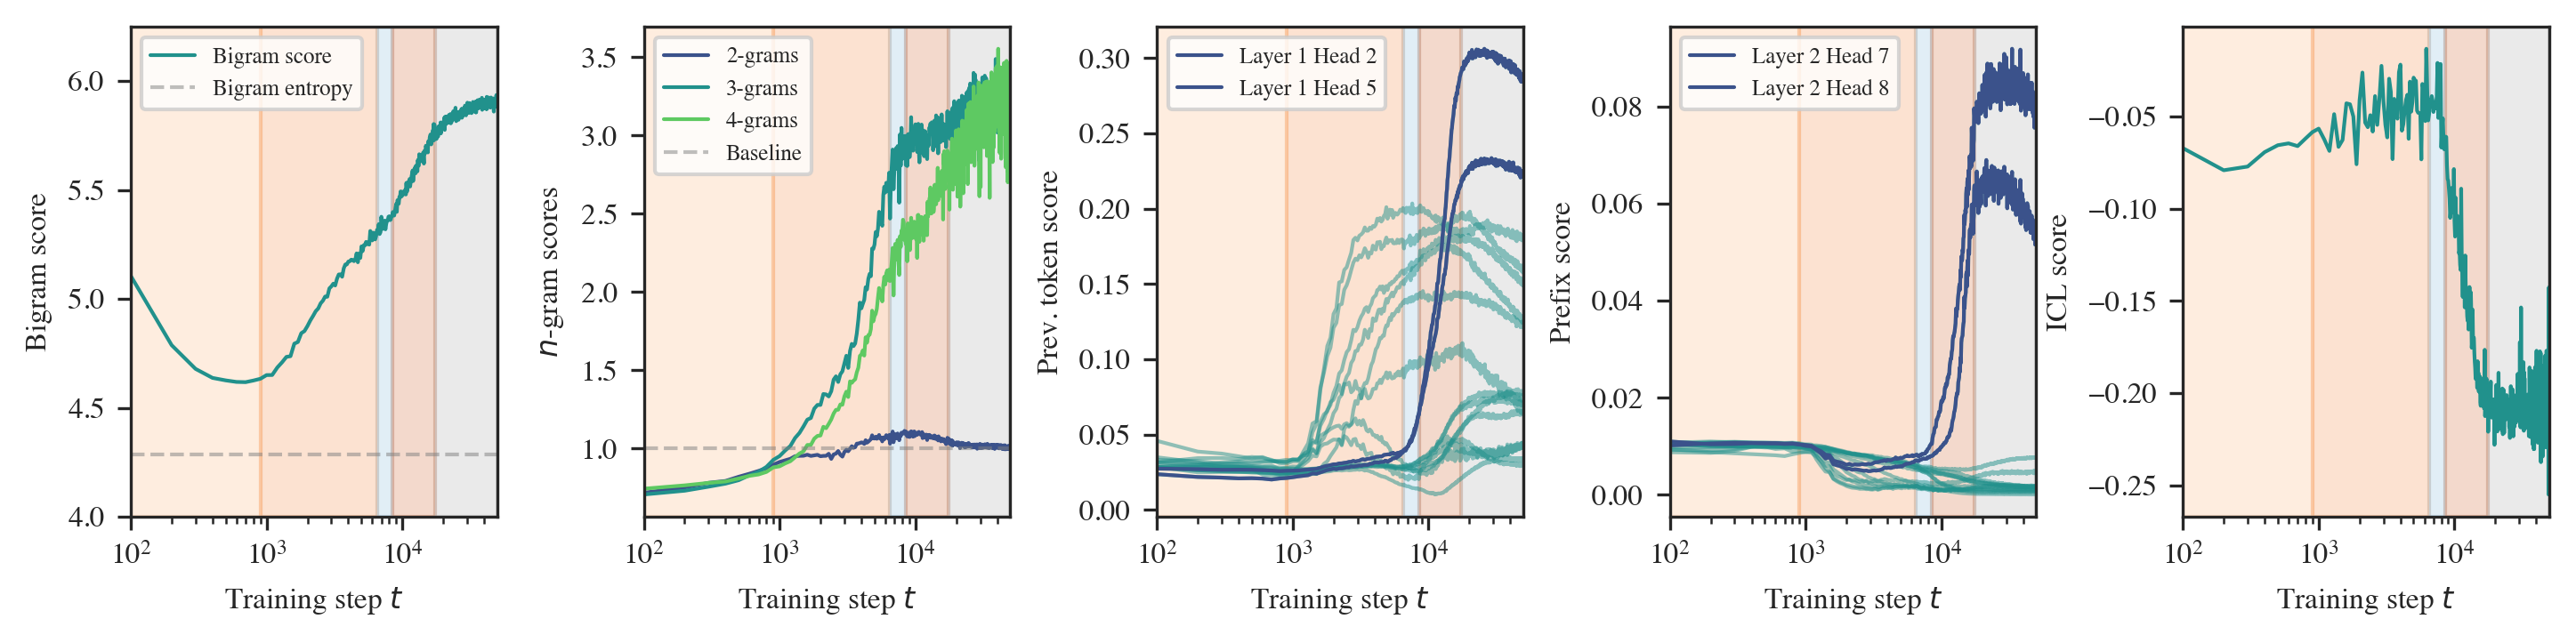

In [99]:
from tqdm import trange

plt.rcParams['figure.dpi'] = 300

palette = 'viridis'
cmap = sns.color_palette(palette, as_cmap=True)


fig, axes = plt.subplots(1, 5, figsize=(WIDTH * 3, HEIGHT * 1.25))


for ax in axes:
    ax.set_xscale('log')
    ax.set_xlim(100, 50_000)
    ax.set_xlabel('Training step $t$')

ax0, ax1, ax3, ax2, ax4 = axes

# metrics = ['pretrain/mse', 'llc/mean/mean', 'loss_0/mean', 'icl_score']
# labels = ['Test loss $\hat{\ell}(w_t)$', 'Local learning coeff. $\hat\lambda(w_t)$', 'Avg. per-token norm', 'ICL score']

metrics = ['bigram_score', None, None, None, 'icl_score']
labels = ['Bigram score', None, None, None, 'ICL score']

sns.lineplot(df, x='step', y='bigram_score', ax=ax0, lw=LW, c=cmap(0.5), label='Bigram score')
ax0.set_ylim(4., 6.25)
ax0.axhline(bigram_entropy, color='gray', linestyle='--', linewidth=1, alpha=0.5, label='Bigram entropy')
ax0.legend(loc='upper left', fontsize=6)
ax0.set_ylabel('Bigram score')

# ax1
loss = np.array(loss)
        
ax1.plot(steps, loss / np.array(ngrams[(2, 2)]), lw=LW, label='2-grams', c=cmap(0.25))
ax1.plot(steps, loss / np.array(ngrams[(3, 2)]), lw=LW, label='3-grams', c=cmap(0.5))
ax1.plot(steps, loss / np.array(ngrams[(4, 2)]), lw=LW, label='4-grams', c=cmap(0.75))
ax1.axhline(1, color='gray', linestyle='--', linewidth=1, alpha=0.5, label='Baseline')
ax1.set_ylabel('$n$-gram scores')

ax1.legend(fontsize=6)

for l in range(2):
    for h in range(8):
        ax2.plot(steps, prefix_scores[:, l, h], lw=LW, label=f'_Layer {l+1} Head {h+1}', alpha=0.5, c=cmap(0.5))

ax2.plot(steps, prefix_scores[:, 1, 6], lw=LW, label=f'Layer {2} Head {7}', c=cmap(0.25))
ax2.plot(steps, prefix_scores[:, 1, 7], lw=LW, label=f'Layer {2} Head {8}', c=cmap(0.25))

ax2.legend(fontsize=6)
ax2.set_ylabel('Prefix score')


for l in range(2):
    for h in range(8):
        ax3.plot(steps, prev_scores[:, l, h], lw=LW, label=f'_Layer {l+1} Head {h+1}', alpha=0.5,  c=cmap(0.5))

ax3.set_ylabel('Prev. token score')
ax3.plot(steps, prev_scores[:, 0, 1], lw=LW, label=f'Layer {1} Head {2}', c=cmap(0.25))
ax3.plot(steps, prev_scores[:, 0, 4], lw=LW, label=f'Layer {1} Head {5}', c=cmap(0.25))
ax3.legend(fontsize=6)

sns.lineplot(df, x='step', y='icl_score', ax=ax4, lw=LW, c=cmap(0.5))
ax4.set_ylabel('ICL score')


plot_transitions(axes, TRANSITIONS, colors=colors)


# plt.suptitle("Step 0 (LR1)")
plt.tight_layout()
plt.subplots_adjust(wspace=0.4, hspace=0.3)

plt.show()

# # Create the animation
# ani = animation.FuncAnimation(fig, animate, frames=tqdm.tqdm(ed_steps[1::1000]), interval=10, repeat_delay=2000)

# # fig.set_facecolor('white')
# # ani.save(FIGURES / f"lr-details.gif", writer='pillow')
# # plt.show()